<div style="background-color: #ccffcc; padding: 10px;">

# Section 1: Introduction

This mini-project explores the application of auto-encoders to predict important hydraulic properties of porous materials. We will initially focus on estimating two key properties: hydraulic permeability and liquid entry pressure. Next, we are going to use the trained models to design new materials that have certain hydraulic properties.

Porous materials are ubiquitous in nature and engineering applications, from natural substances like wood, rocks, and even our bones to engineered materials like face masks, yoga mats, and concrete. Understanding fluid flow through these materials is crucial for various fields, including chemistry, hydrology, and materials science. In Fig. 1 you can see a few examples of the porous materials, as they consist of a solid phase with interconnected pores or void spaces that allow fluids to flow through or be stored within the material.

![Image description](Fig/Slide1.PNG)

## Hydraulic Permeability

Hydraulic permeability is a measure of a porous material's ability to allow fluids to pass through it. It depends on the material's pore structure, including factors like porosity, pore size distribution, and connectivity. Permeability is typically defined using Darcy's law, which describes the flow of a fluid through a porous medium:
$$Q = -\frac{k A}{\mu} \frac{\Delta P}{L}$$
where Q is the volumetric flow rate, k is the permeability, A is the cross-sectional area, μ is the fluid viscosity, ΔP is the pressure difference, and L is the length of the porous medium. The permeability k is an intrinsic property of the porous material and has units of area (typically m² or Darcy which is equivalent to 9.869233e−13 m²).

In this project to generate a toy dataset we estimate permeability of material images using an empirical correlation proposed by [1] that is based on the cross-sectional image of a flow channel.
The permeability (k) is calculated using the following equation:

$$k = (1.342 \cdot D_{ave}^2 - 0.913 \cdot D_{ave} - 0.381) \cdot \phi \cdot (\text{SpatialRes}^2)$$

where $D_{ave}$ is the average distance map value, $\phi$ is the porosity (volumetric void fraction), and SpatialRes is the spatial resolution of the image expressed in length/pixel unit. Thinking about the cross-section of a flow channel as a binary image, a distance map is showing the distance of every zero pixel in an image from the closest non-zero pixel and it has been found that has a very good correlation with the hydraulic conductivity of the flow channel. However, in this instance we are ignoring the 3-D connectivity of flow channels for simplicity. In Fig. 2 [1] it can be seen that there is a visual similarity between velocity distribution for steady state flow into the channels and relative distance maps, which could be the reason for high correlation. When we generate the dataset, we are going to pretend these permeability values are given as ground truth and we will be making a regressive model to estimate them.

![Image description](Fig/Slide2.PNG)

## Liquid Entry Pressure

Liquid entry pressure, also known as capillary breakthrough pressure, is the minimum pressure required for a non-wetting fluid to displace a wetting fluid from a porous medium. Like the force you need to push the water out of a wet sponge by merely blowing air to it! So it could be a lot! Especially if the sponge pores being tiny! There you have it the Young-Laplace equation for capillary pressure:  

$$P_{entry} = \frac{2\gamma \cos(\theta)}{r}$$

where $\gamma$ is the interfacial tension between the fluids, $\theta$ is the contact angle, and $r$ is the effective pore radius. You can see smaller the pore size, higher the pressure needed to flush the residing fluid.

Liquid entry pressure is crucial in applications involving multiphase flow, designing non-wetting fabrics, membrane filtration, and water desalination. In this toy example, we will be calculating this pressure based on the almost largest pore we find in the porous media image, but then we are going to pretend this number has been given as a ground truth and trying to estimate it using neural networks without the knowlege on the physics.

## Importance in Membrane Science

In membrane science, hydraulic permeability and liquid entry pressure are critical parameters:

1. **Hydraulic Permeability**: Determines flux through the membrane.
2. **Liquid Entry Pressure**: Crucial for preventing liquid penetration in gas-liquid separation.

These properties significantly influence membrane performance and present important trade-offs. For example, in membrane distillation:

Membrane distillation is a thermally-driven separation process where only vapor molecules transfer through a microporous hydrophobic membrane, driven by a vapor pressure difference (Fig. 3)  [2]. This process can be used to desalinate water. There is a delicate balance on membrane hydraulic propertise as:

- Higher permeability → Increased water vapor flux, but potential for reduced liquid entry pressure
- Lower permeability → Better liquid-gas separation, but decreased overall flux

Balancing these properties is key to optimizing membrane performance and having an efficient and cost-effective filtration system.

![Image description](Fig/Slide3.PNG)

</div>

<hr>

<div style="background-color: #e6ccff; padding: 10px;">

## Auto-encoders: A Brief Overview

Auto-encoders are a type of artificial neural network used for unsupervised learning and dimensionality reduction. They consist of two main parts:

1. **Encoder**: Compresses the input data into a lower-dimensional representation (latent space).
2. **Decoder**: Reconstructs the original input from the latent space representation.

Mathematically, for an input $x$, the encoder function $f(x)$ maps it to a latent representation $z$:

$$z = f(x) = \sigma(Wx + b)$$

where $W$ is a weight matrix, $b$ is a bias vector, and $\sigma$ is an activation function.

The decoder function $g(z)$ then attempts to reconstruct the input:

$$\hat{x} = g(z) = \sigma'(W'z + b')$$

The auto-encoder is trained to minimize the reconstruction error [3]:

$$L(x, \hat{x}) = \|x - \hat{x}\|^2$$

In this project, we use auto-encoders to learn compact representations of porous material images (latent space). These representations are then used to predict hydraulic properties in a regressive approach. In the figure below, an example of using autoencoders for a regressive model is depicted. The input and output image is a hand written digit "7" from the MNIST dataset.

![Image description](Fig/Slide4.PNG)


## References

[1] Rabbani, A., & Babaei, M. (2019), *Advances in water resources*, *126*, 116-128.

[2] Khan et al.(2022), *Sustainability*, 14(20), 13535.

[3] Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.

</div>

<div style="background-color: #ccffcc; padding: 10px;">

# Section 2: Creating the dataset

This step, we create a toy dataset of porous material images by thresholding Gaussian-smoothed random 2D fields. The images will be binary with 1 representing the solid phase and 0 representing the void (pore) phase in which fluid can flow. As a result we will have structures with variablity in pore size and porosity. Then hydraulic permeability and liquid entry pressure are calculated using the discussed methods. Below are the steps:

1. **Image Generation**
   - Create 2000 128x128 random noise images
   - Apply Gaussian smoothing (sigma: 2-5) with circular padding
   - Add random shifts

2. **Thresholding**
   - Apply percentile thresholding (30th-70th percentile)
   - Create binary images (1: solid, 0: void)

3. **Property Calculation**
   - Porosity: Mean of binary values (fraction of pore space)
   - Entry Pressure: Smoothed distance transform and use of 95th percentile in Young-Laplace equation as for the largest pore size
   - Permeability: Empirical correlation based on average distance map and porosity

4. **Data Preprocessing**
   - Split: 80% train, 20% test
   - Log transform and normalize properties

5. **Visualization**
   - Sample images
   - Property distributions
   - Dataset statistics

</div>

<div style="background-color: #cce5ff; padding: 10px;">

# Python

## [PyTorch](https://pytorch.org/)

PyTorch is an open-source machine learning library developed by Facebook's AI Research lab. It is widely used for applications such as natural language processing and computer vision. PyTorch is known for its flexibility and ease of use, particularly due to its dynamic computation graph, which allows for more intuitive model building and debugging. However, it is considered quite low-level compared to some other frameworks (e.g. [Keras](https://keras.io/)), meaning that defining complex models like a U-Net can require a significant amount of verbose code. This verbosity can make the development process more cumbersome, especially for those who are new to deep learning.

## [scikit learn](https://scikit-learn.org/stable/)
SciKit Learn is an open-source machine learning library featuring several regression, classification and clustering algorithms e.g. random forests and k-means clustering. Its designed to work hand in hand with Numpy and SciPy.

## Further reading

If you want to run this notebook locally or on a remote service:

* [running Jupyter notebooks](https://jupyter.readthedocs.io/en/latest/running.html)
* [running the Jupyter notebooks locally](https://github.com/cemac/LIFD_CDT_ML_NOTEBOOKS/blob/main/howtorun.md)

</div>

<hr>

<div style="background-color: #ffffcc; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run with the following requirements satisfied.

<h2> Python Packages: </h2>

* PyTorch
* sci-kit learn 
* sci-py
* numpy
* matplotlib
* seaborn


</div>

<div style="background-color: #cce5ff; padding: 10px;">

## Import modules

These are all the modules needed during this tutorial and turn off warnings

</div>

In [ ]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

# Import modules
import numpy as np
from scipy.ndimage import distance_transform_edt, gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import dirichlet


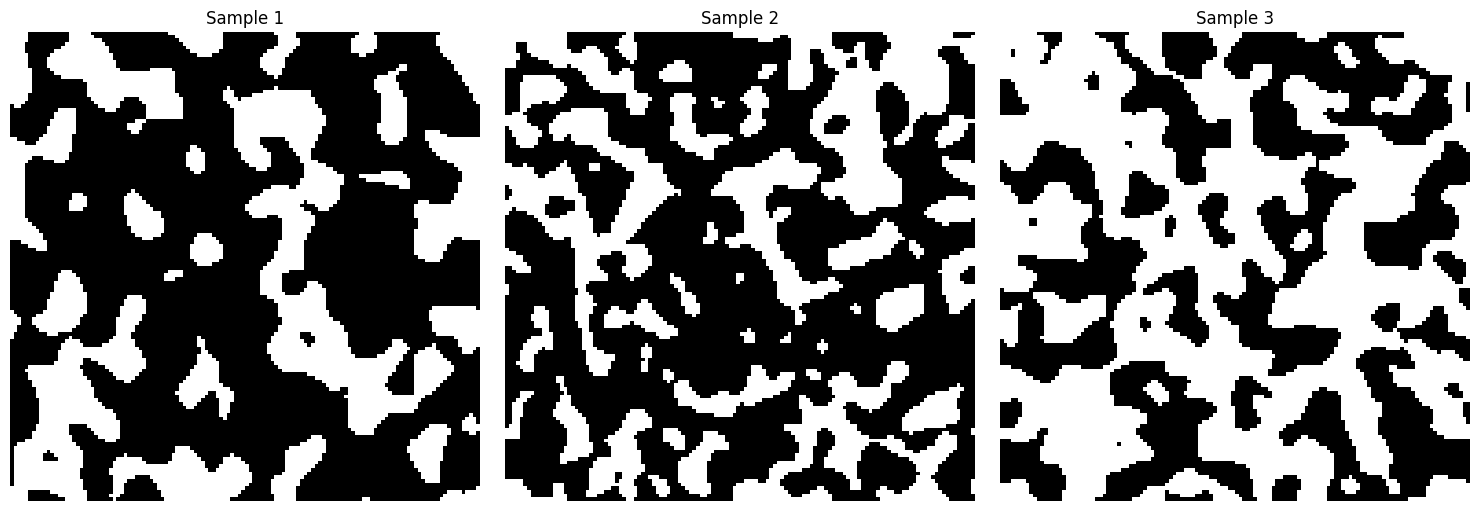

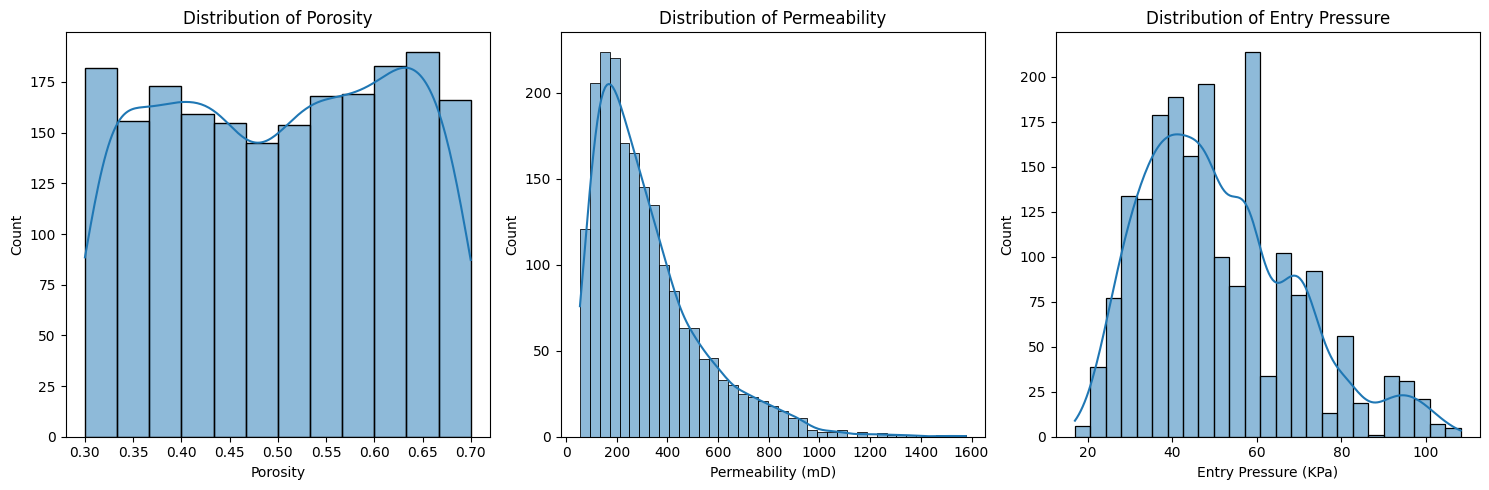

Number of training samples: 1600
Number of test samples: 400
Image shape: (128, 128, 1)
Porosity range: 0.300 - 0.700
Permeability range: 54.687 - 1576.987
Entry pressure range: 16.939 - 108.264


In [1]:
# Set random seed for reproducibility
np.random.seed(42)

def generate_dataset(num_samples=2000):
    Spatial_Res = 5  # Spatial resolution 5 micron/pixel
    images = np.random.rand(num_samples, 128, 128, 1)  # Random noise as porous media images

    # Apply Gaussian smoothing with random sigma to create spatial correlation
    for i in range(num_samples):
        smoothing_sigma = np.random.uniform(2, 5)
        img = images[i].squeeze()

        # Pad the image with circular boundary conditions
        pad_width = int(4 * smoothing_sigma)  # Adjust padding based on sigma
        padded_img = np.pad(img, pad_width, mode='wrap')

        # Apply Gaussian filter
        smoothed_img = gaussian_filter(padded_img, sigma=smoothing_sigma)

        # Crop back to original size
        images[i] = smoothed_img[pad_width:-pad_width, pad_width:-pad_width].reshape(128, 128, 1)

    # Apply random shifts
    for i in range(num_samples):
        shift_x = np.random.randint(-6, 7)
        shift_y = np.random.randint(-6, 7)
        images[i] = np.roll(images[i], (shift_y, shift_x), axis=(0, 1))

    # Apply percentile thresholding
    for i in range(num_samples):
        img = images[i].squeeze()
        lower_percentile = np.percentile(img, 30)
        upper_percentile = np.percentile(img, 70)
        threshold = np.random.uniform(lower_percentile, upper_percentile)
        images[i] = (img > threshold).astype(float).reshape(128, 128, 1)
    porosities = images.mean(axis=(1, 2, 3))  # Average porosity

    # Calculate liquid entry pressure using 95th percentile
    entry_pressures = []
    permeabilities = []
    for i in range(num_samples):
        img = images[i]
        dist_transform = distance_transform_edt(1 - img.squeeze())
        dist_transform = gaussian_filter(dist_transform, sigma=0.5)
        r_95 = np.percentile(dist_transform, 95)
        Theta = 0
        IFT = 0.72  # Newton/meter Air water interfacial tension
        entry_pressure = 2 * np.cos(Theta) * IFT / (r_95 + 1e-6) / (Spatial_Res * 1e-6) / 1e3  # Kilo pascal (KPa)
        entry_pressures.append(entry_pressure)
        dist_transform = dist_transform + 1
        D_ave = np.mean(dist_transform[dist_transform != 1])
        permeability = (1.342 * (D_ave**2) - 0.913 * D_ave - .381) *  Spatial_Res**2  # Milli darcy (mD)
        permeabilities.append(permeability)

    entry_pressures = np.array(entry_pressures)
    permeabilities = np.array(permeabilities)

    return images, permeabilities, entry_pressures, porosities

# Generate dataset
images, permeabilities, entry_pressures, porosities = generate_dataset()

# Split dataset
split = int(0.8 * len(images))
train_images, test_images = images[:split], images[split:]
train_permeabilities, test_permeabilities = permeabilities[:split], permeabilities[split:]
train_entry_pressures, test_entry_pressures = entry_pressures[:split], entry_pressures[split:]

# Normalize permeabilities and entry pressures using log transformation
def normalize_data(train_data, test_data):
    train_data_log = np.log1p(train_data)
    test_data_log = np.log1p(test_data)
    data_mean = train_data_log.mean()
    data_std = train_data_log.std()
    train_data_norm = (train_data_log - data_mean) / data_std
    test_data_norm = (test_data_log - data_mean) / data_std
    return train_data_norm, test_data_norm, data_mean, data_std

train_permeabilities_norm, test_permeabilities_norm, perm_mean, perm_std = normalize_data(train_permeabilities, test_permeabilities)
train_entry_pressures_norm, test_entry_pressures_norm, ep_mean, ep_std = normalize_data(train_entry_pressures, test_entry_pressures)

norm_params = {
    'perm_mean': perm_mean,
    'perm_std': perm_std,
    'ep_mean': ep_mean,
    'ep_std': ep_std
}


# Visualize a few sample images
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(train_images[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Plot distribution of porosity, permeability, and entry pressure
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(porosities, kde=True)
plt.title("Distribution of Porosity")
plt.xlabel("Porosity")

plt.subplot(1, 3, 2)
sns.histplot(permeabilities, kde=True)
plt.title("Distribution of Permeability")
plt.xlabel("Permeability (mD)")

plt.subplot(1, 3, 3)
sns.histplot(entry_pressures, kde=True)
plt.title("Distribution of Entry Pressure")
plt.xlabel("Entry Pressure (KPa)")

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of training samples: {len(train_images)}")
print(f"Number of test samples: {len(test_images)}")
print(f"Image shape: {train_images[0].shape}")
print(f"Porosity range: {porosities.min():.3f} - {porosities.max():.3f}")
print(f"Permeability range: {permeabilities.min():.3f} - {permeabilities.max():.3f}")
print(f"Entry pressure range: {entry_pressures.min():.3f} - {entry_pressures.max():.3f}")

<div style="background-color: #ccffcc; padding: 10px;">

## Section 3: Predicting Hydraulic Permeability

This section focuses on developing and implementing a machine learning model to predict the hydraulic permeability of porous materials. The process involves:

1. Preparing and preprocessing the data, including normalization of permeability values and splitting the dataset into training and testing sets

2. Designing and implementing an autoencoder architecture, consisting of an encoder and decoder, to learn compact representations of porous material images

3. Training the autoencoder using Mean Squared Error (MSE) loss and the Adam optimizer, visualizing the reconstruction capabilities to ensure effective learning

4. Generating latent space representations for the training and test data using the trained encoder

5. Designing and training a regressor model that takes the latent space representations as input and predicts permeability values

6. Evaluating the model's performance using metrics such as Mean Absolute Error (MAE) and R-squared score

7. Visualizing the results through scatter plots of actual vs. predicted permeability and analyzing the distribution of prediction errors

</div>


Using device: cuda
Loading and preprocessing data...
X_train shape: torch.Size([1600, 1, 128, 128])
X_test shape: torch.Size([400, 1, 128, 128])
y_train shape: torch.Size([1600])
y_test shape: torch.Size([400])
Defining autoencoder architecture...
Initializing autoencoder...
Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=16384, out_features=2048, bias=True)
      (8): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2048, out_features=16384, bias=True)
      (1): ReLU()
      (2): Unflatten(dim=1, unflattened_size=(64, 16, 16))
      (3): ConvTranspose2d(64, 64, kernel_size

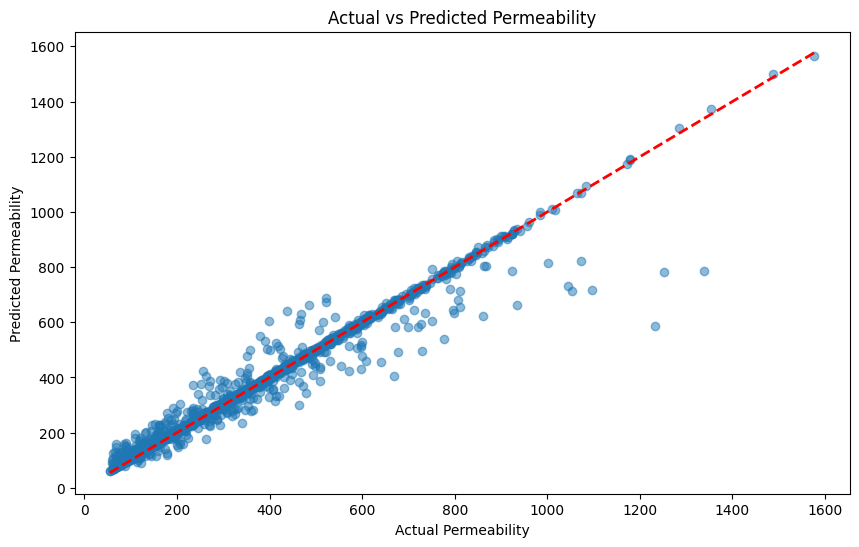

R-squared score: 0.9631
Showing 5 examples of autoencoder input and output


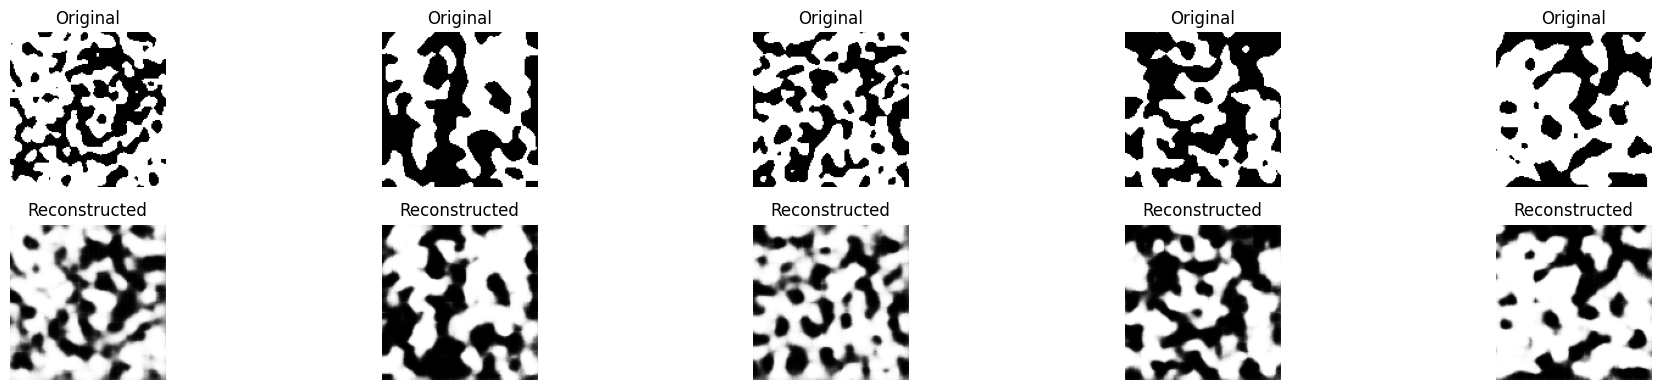

Process completed!


In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading and preprocessing data...")
# Assuming images and permeabilities are already defined from previous sections

# Normalize the target variables
permeability_scaler = StandardScaler()
normalized_permeabilities = permeability_scaler.fit_transform(permeabilities.reshape(-1, 1)).flatten()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, normalized_permeabilities, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and reshape
X_train = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
X_test = torch.FloatTensor(X_test).permute(0, 3, 1, 2)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)  # Removed num_workers and pin_memory
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print("Defining autoencoder architecture...")
latent_dim = 2048

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, latent_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 16 * 16),
            nn.ReLU(),
            nn.Unflatten(1, (64, 16, 16)),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

print("Initializing autoencoder...")
autoencoder = Autoencoder().to(device)
print(autoencoder)

print("Compiling and training autoencoder...")
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)

n_epochs = 20
try:
    for epoch in range(n_epochs):
        autoencoder.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = autoencoder(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_loss/len(train_loader):.4f}')
except RuntimeError as e:
    print(f"RuntimeError occurred: {e}")
    print("Falling back to CPU...")
    device = torch.device("cpu")
    autoencoder = autoencoder.to(device)
    # Retry training on CPU
    for epoch in range(n_epochs):
        autoencoder.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = autoencoder(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_loss/len(train_loader):.4f}')

print("Creating latent space representations...")
autoencoder.eval()
latent_train = []
latent_test = []

with torch.no_grad():
    for data, _ in train_loader:
        data = data.to(device)
        latent_train.append(autoencoder.encoder(data).cpu())
    for data, _ in test_loader:
        data = data.to(device)
        latent_test.append(autoencoder.encoder(data).cpu())

latent_train = torch.cat(latent_train, dim=0)
latent_test = torch.cat(latent_test, dim=0)

print(f"Latent train shape: {latent_train.shape}")
print(f"Latent test shape: {latent_test.shape}")

print("Defining and training regressor...")
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

regressor = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters())

n_epochs = 300
for epoch in range(n_epochs):
    regressor.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        latent = autoencoder.encoder(data)
        optimizer.zero_grad()
        output = regressor(latent)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_loss/len(train_loader):.4f}')

print("Evaluating the model...")
regressor.eval()
train_mae = 0
test_mae = 0

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        latent = autoencoder.encoder(data)
        output = regressor(latent)
        train_mae += nn.L1Loss()(output.squeeze(), target).item()

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        latent = autoencoder.encoder(data)
        output = regressor(latent)
        test_mae += nn.L1Loss()(output.squeeze(), target).item()

train_mae /= len(train_loader)
test_mae /= len(test_loader)

print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

print("Making predictions...")
autoencoder.eval()
regressor.eval()
all_images = torch.FloatTensor(images).permute(0, 3, 1, 2).to(device)
latent_all = autoencoder.encoder(all_images)
predicted_permeabilities = regressor(latent_all).squeeze().cpu().detach().numpy()

# Denormalize the predictions
predicted_permeabilities = permeability_scaler.inverse_transform(predicted_permeabilities.reshape(-1, 1)).flatten()

print("Plotting results...")
# Plot actual vs predicted permeabilities
plt.figure(figsize=(10, 6))
plt.scatter(permeabilities, predicted_permeabilities, alpha=0.5)
plt.plot([permeabilities.min(), permeabilities.max()], [permeabilities.min(), permeabilities.max()], 'r--', lw=2)
plt.xlabel('Actual Permeability')
plt.ylabel('Predicted Permeability')
plt.title('Actual vs Predicted Permeability')
plt.show()

# Calculate and print R-squared score
from sklearn.metrics import r2_score
r2 = r2_score(permeabilities, predicted_permeabilities)
print(f"R-squared score: {r2:.4f}")

# Visualize input and output of autoencoder
print('Showing 5 examples of autoencoder input and output')
n = 5  # number of images to display
with torch.no_grad():
    decoded_images = autoencoder(X_test[:n].to(device)).cpu().numpy()

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].cpu().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Process completed!")

Have a look at the reconstructed samples above, they should have a pixel-wise similarity to the original images that are picked from the test dataset.

<div style="background-color: #ccffcc; padding: 10px;">

## Section 4: Entry Pressure Prediction

This section focuses on applying the autoencoder and regression approach to predict the entry pressure of porous materials. Similar to the permeability prediction, we utilize the latent space representations learned by the autoencoder to estimate entry pressure values. The process involves:

1. Utilizing the pre-trained encoder from the permeability prediction task
2. Creating latent space representations for entry pressure data
3. Designing and training a new regressor model specifically for entry pressure prediction
4. Evaluating the model's performance using metrics such as Mean Absolute Error (MAE) and R-squared score
5. Visualizing the results through scatter plots of actual vs. predicted entry pressures

</div>

Using device: cuda
Loading and preprocessing data for entry pressure prediction...
X_train shape: torch.Size([1600, 1, 128, 128])
X_test shape: torch.Size([400, 1, 128, 128])
y_train shape: torch.Size([1600])
y_test shape: torch.Size([400])
Using the pre-trained encoder...
Creating latent space representations...
Latent train shape: torch.Size([1600, 2048])
Latent test shape: torch.Size([400, 2048])
Defining and training regressor for entry pressure...
Epoch 50/300, Loss: 0.0030
Epoch 100/300, Loss: 0.0069
Epoch 150/300, Loss: 0.0102
Epoch 200/300, Loss: 0.0035
Epoch 250/300, Loss: 0.0107
Epoch 300/300, Loss: 0.0008
Evaluating the model...
Train MAE: 0.0197
Test MAE: 0.2436
Making predictions...
R-squared score for Entry Pressure: 0.9771
Plotting results...


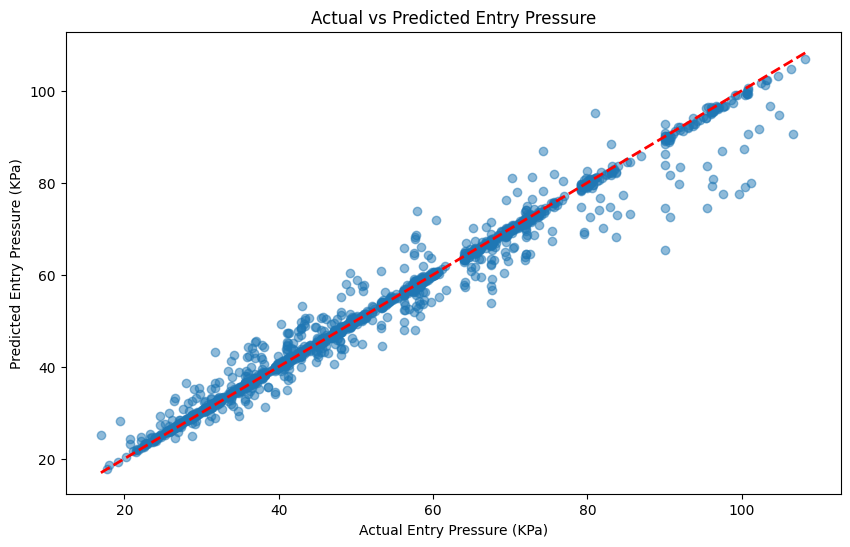

Process completed!


In [3]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading and preprocessing data for entry pressure prediction...")
# Normalize the entry pressure
entry_pressure_scaler = StandardScaler()
normalized_entry_pressures = entry_pressure_scaler.fit_transform(entry_pressures.reshape(-1, 1)).flatten()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, normalized_entry_pressures, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and reshape
X_train = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
X_test = torch.FloatTensor(X_test).permute(0, 3, 1, 2)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Using the pre-trained encoder...")
# The encoder is already trained from the permeability prediction
# Make sure the autoencoder is in evaluation mode
autoencoder.eval()

print("Creating latent space representations...")
latent_train = []
latent_test = []

with torch.no_grad():
    for data, _ in train_loader:
        data = data.to(device)
        latent_train.append(autoencoder.encoder(data).cpu())
    for data, _ in test_loader:
        data = data.to(device)
        latent_test.append(autoencoder.encoder(data).cpu())

latent_train = torch.cat(latent_train, dim=0)
latent_test = torch.cat(latent_test, dim=0)

print(f"Latent train shape: {latent_train.shape}")
print(f"Latent test shape: {latent_test.shape}")

print("Defining and training regressor for entry pressure...")
class Regressor(nn.Module):
    def __init__(self, latent_dim):
        super(Regressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

regressor_ep = Regressor(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor_ep.parameters())

n_epochs = 300
for epoch in range(n_epochs):
    regressor_ep.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        latent = autoencoder.encoder(data)
        optimizer.zero_grad()
        output = regressor_ep(latent)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_loss/len(train_loader):.4f}')

print("Evaluating the model...")
regressor_ep.eval()
train_mae = 0
test_mae = 0

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        latent = autoencoder.encoder(data)
        output = regressor_ep(latent)
        train_mae += nn.L1Loss()(output.squeeze(), target).item()

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        latent = autoencoder.encoder(data)
        output = regressor_ep(latent)
        test_mae += nn.L1Loss()(output.squeeze(), target).item()

train_mae /= len(train_loader)
test_mae /= len(test_loader)

print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

print("Making predictions...")
all_images = torch.FloatTensor(images).permute(0, 3, 1, 2).to(device)
latent_all = autoencoder.encoder(all_images)
predicted_entry_pressures = regressor_ep(latent_all).squeeze().cpu().detach().numpy()

# Denormalize the predictions
predicted_entry_pressures = entry_pressure_scaler.inverse_transform(predicted_entry_pressures.reshape(-1, 1)).flatten()

# Calculate and print R-squared score for entry pressure
r2_entry = r2_score(entry_pressures, predicted_entry_pressures)
print(f"R-squared score for Entry Pressure: {r2_entry:.4f}")


print("Plotting results...")
# Plot actual vs predicted entry pressures
plt.figure(figsize=(10, 6))
plt.scatter(entry_pressures, predicted_entry_pressures, alpha=0.5)
plt.plot([entry_pressures.min(), entry_pressures.max()], [entry_pressures.min(), entry_pressures.max()], 'r--', lw=2)
plt.xlabel('Actual Entry Pressure (KPa)')
plt.ylabel('Predicted Entry Pressure (KPa)')
plt.title('Actual vs Predicted Entry Pressure')
plt.show()

print("Process completed!")


<div style="background-color: #e6ccff; padding: 10px;">

# Section 5: Generating membrane structure with desired properties

This section focuses on generating a membrane structure with specified hydraulic properties using an optimization approach based on the latent space representation learned by our autoencoder.

## Methodology

1. **Target Selection**: We randomly select a sample from the test dataset as our target, providing us with a reference point for desired permeability and entry pressure values.

2. **Similar Sample Identification**: We identify the 10 most similar samples from the training set based on Euclidean distance in the permeability-entry pressure space. This approach leverages the assumption that the optimal geometry's latent representation may be approximated by a combination of known samples.

3. **Latent Space Interpolation**: We hypothesize that the latent space representation of the optimal geometry can be approximated by a weighted combination of the latent representations of these similar samples.

4. **Optimization Process**: We employ a random search optimization algorithm to find the optimal weights for combining the latent representations. The objective function minimizes the squared relative errors in both permeability and entry pressure predictions.

## Optimization Algorithm

We use an improved random search optimization with the following steps:

1. Initialize weights using a Dirichlet distribution to ensure they sum to 1.
2. In each iteration:
   a. Perturb the current best weights using Gaussian noise.
   b. Clip weights to ensure non-negativity and normalize to sum to 1.
   c. Evaluate the objective function for the new weights.
   d. Update the best solution if an improvement is found.

## Objective Function

The objective function is defined as:

$$f(\mathbf{w}) = \left(\frac{k_{pred} - k_{target}}{k_{target}}\right)^2 + \left(\frac{p_{pred} - p_{target}}{p_{target}}\right)^2$$

Where:
- $\mathbf{w}$ is the weight vector
- $k_{pred}$ and $p_{pred}$ are the predicted permeability and entry pressure
- $k_{target}$ and $p_{target}$ are the target permeability and entry pressure

</div>

<div style="background-color: #ccffcc; padding: 10px;">

## Results Visualization

We visualize the results by comparing:
1. The target and generated membrane images
2. The target and achieved permeability and entry pressure values
3. The optimization process convergence
4. The final weight distribution for the optimal solution

This approach allows us to generate membrane structures with desired hydraulic properties by exploiting the learned latent space representation and optimizing within this space.

</div>

Using device: cuda
Selecting a random sample from the test set as the target...
Target Permeability: 257.8508
Target Entry Pressure: 49.5596
Finding similar samples from the training set...
Defining optimization function...
Running optimization...
Iteration 0, Best Error: 0.004570
Iteration 50, Best Error: 0.000322
Iteration 100, Best Error: 0.000074
Iteration 150, Best Error: 0.000067
Iteration 200, Best Error: 0.000006
Iteration 250, Best Error: 0.000006
Generating optimal membrane structure...
Optimal Permeability: 258.2766
Optimal Entry Pressure: 49.4696
Visualizing results...


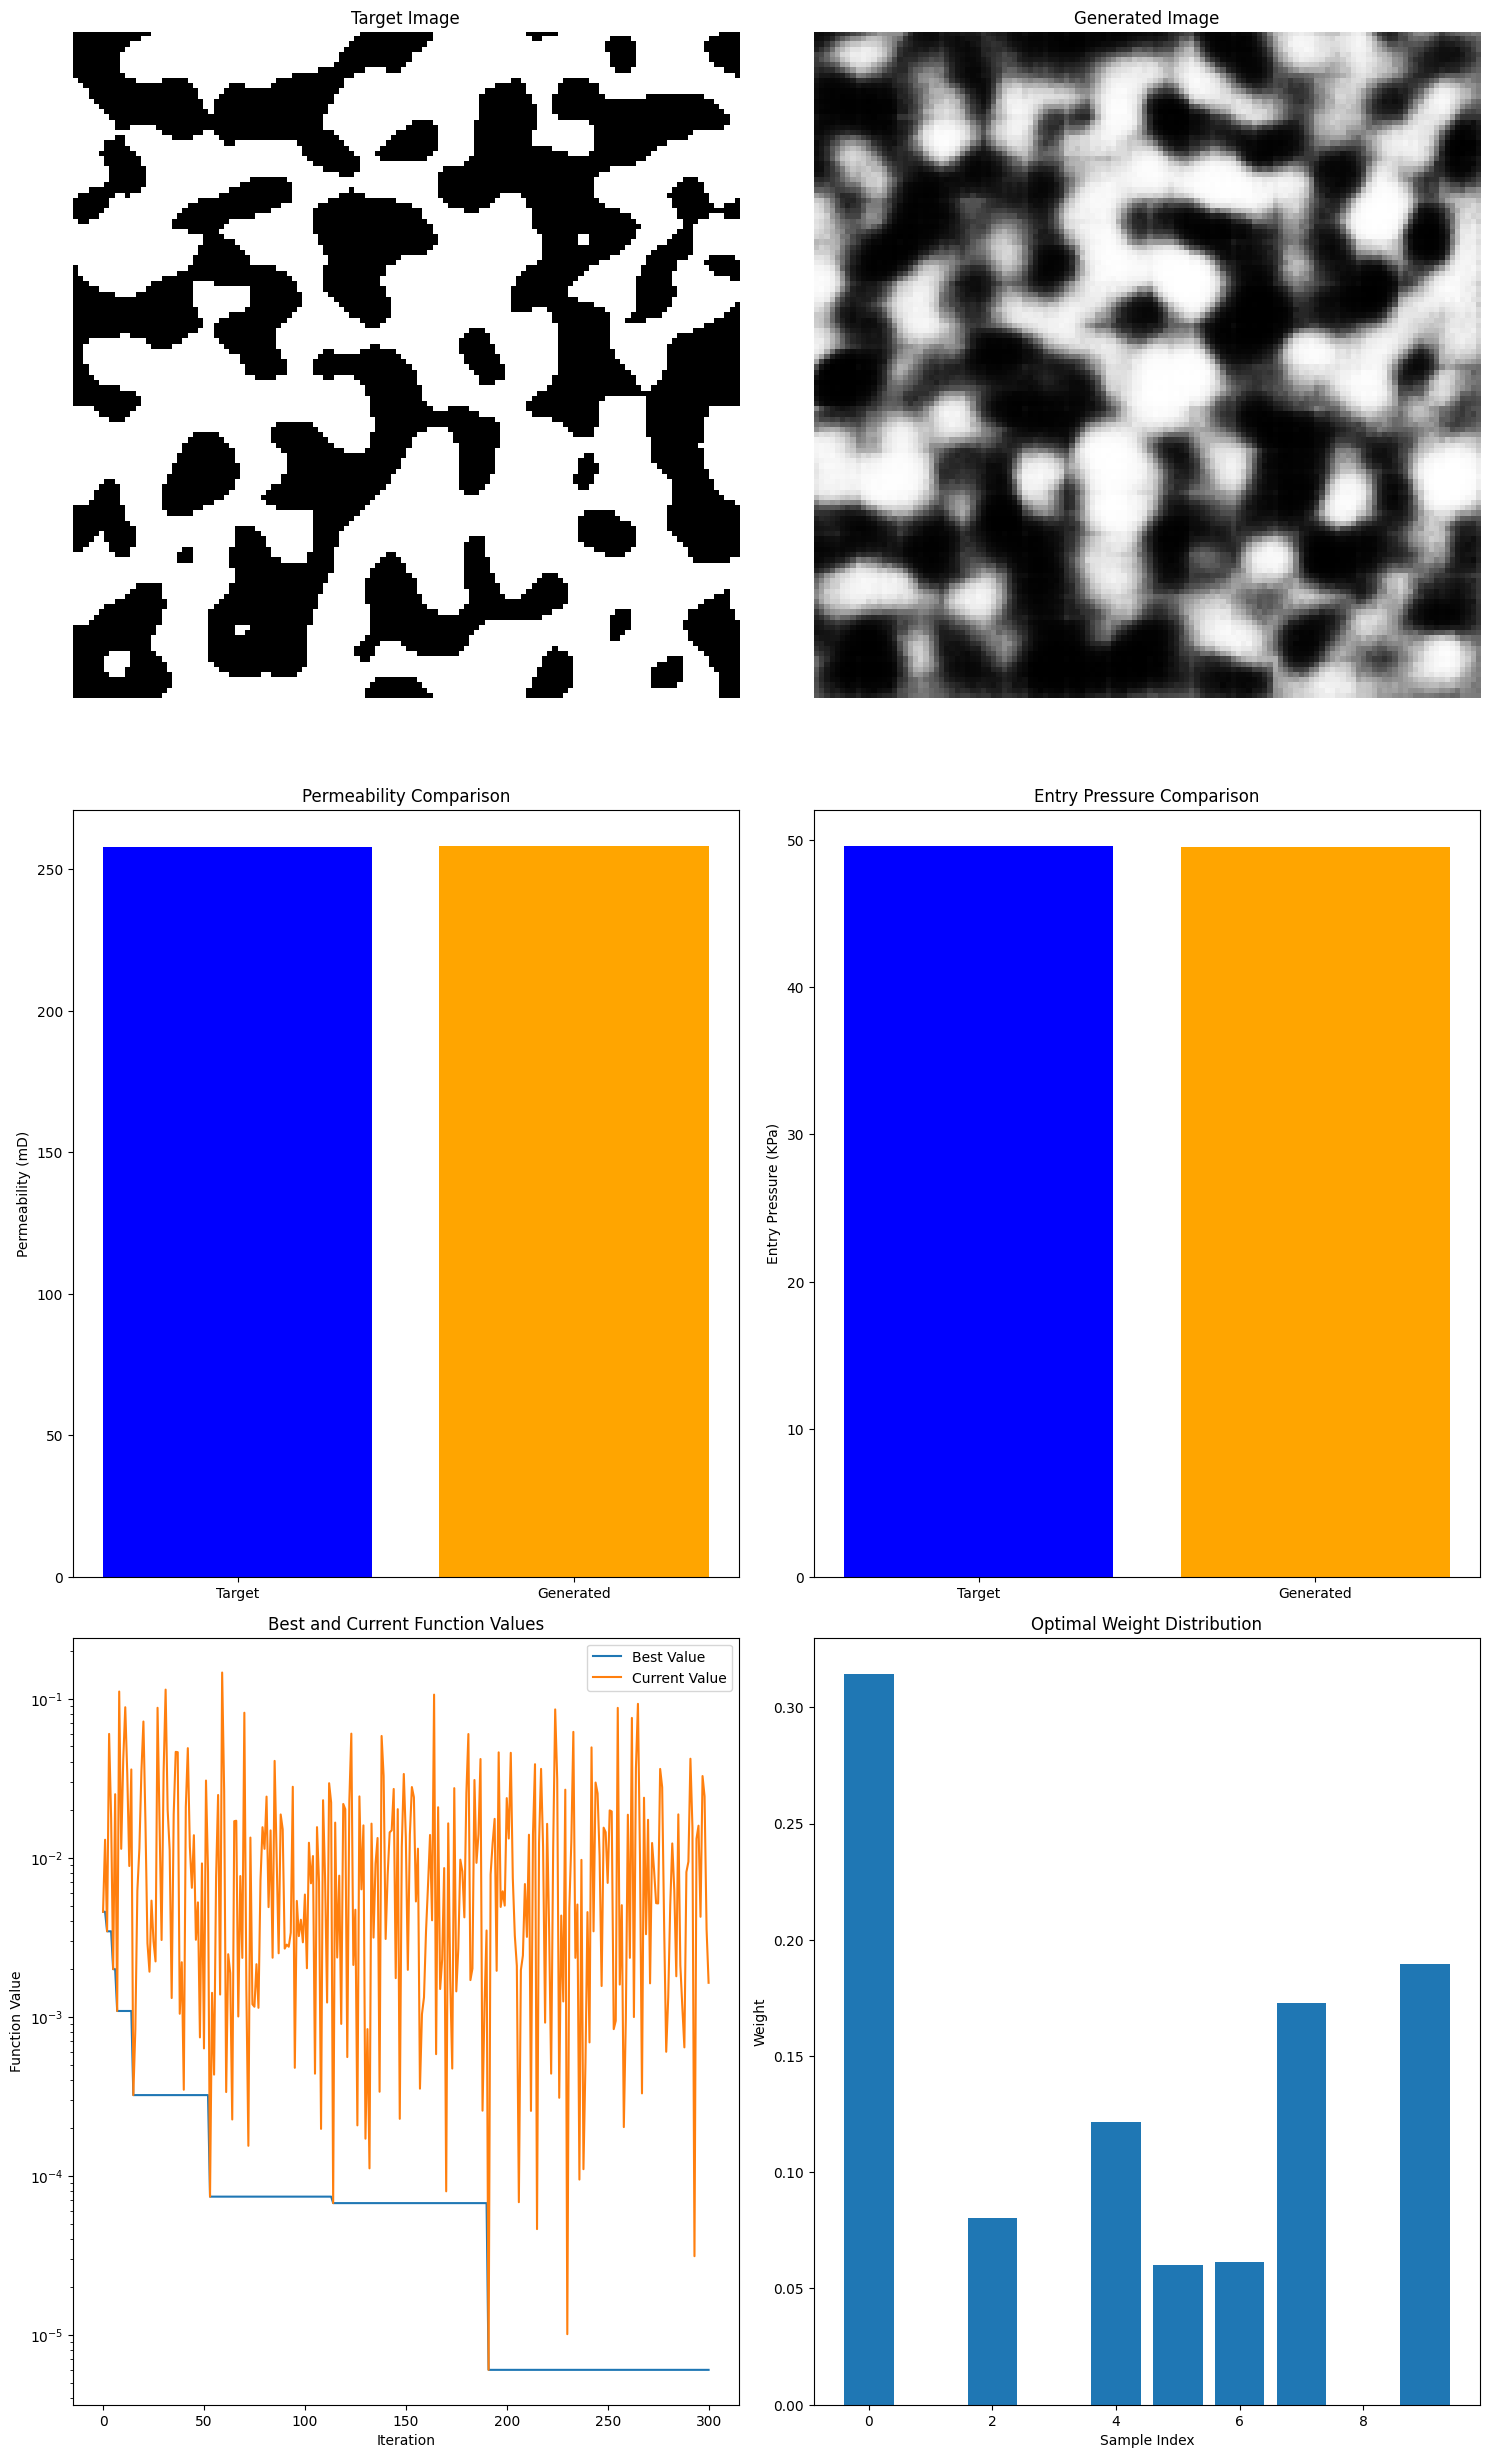

Process completed!


In [4]:


# Ensure we're using the same device as before
print(f"Using device: {device}")

print("Selecting a random sample from the test set as the target...")
# Select a random sample from the test set as the target
target_index = np.random.randint(0, len(X_test))
target_image = X_test[target_index].unsqueeze(0)  # Add batch dimension
target_perm = test_permeabilities[target_index]
target_ep = test_entry_pressures[target_index]

print(f"Target Permeability: {target_perm:.4f}")
print(f"Target Entry Pressure: {target_ep:.4f}")

print("Finding similar samples from the training set...")
# Find the 10 most similar samples from the training set in terms of permeability and entry pressure
distances = np.sqrt((train_permeabilities - target_perm)**2 + (train_entry_pressures - target_ep)**2)
similar_indices = np.argsort(distances)[:10]

similar_images = X_train[similar_indices]
with torch.no_grad():
    similar_latents = autoencoder.encoder(similar_images.to(device)).cpu().numpy()

print("Defining optimization function...")
def objective(weights):
    weighted_latent = np.sum(similar_latents * weights[:, np.newaxis], axis=0)
    weighted_latent_tensor = torch.FloatTensor(weighted_latent).unsqueeze(0).to(device)

    # Predict properties from the weighted latent
    with torch.no_grad():
        pred_perm = permeability_scaler.inverse_transform(regressor(weighted_latent_tensor).cpu().numpy())[0][0]
        pred_ep = entry_pressure_scaler.inverse_transform(regressor_ep(weighted_latent_tensor).cpu().numpy())[0][0]

    # Calculate error
    perm_error = ((pred_perm - target_perm) / target_perm)**2
    ep_error = ((pred_ep - target_ep) / target_ep)**2
    total_error = perm_error + ep_error

    return total_error

def normalize_weights(weights):
    return weights / np.sum(weights)

print("Running optimization...")
# Improved random search optimization
num_iterations = 300
best_weights = np.random.dirichlet(np.ones(10), size=1)[0]  # Initial guess
best_error = objective(best_weights)
best_values = [best_error]
current_values = [best_error]

step_size = 0.1  # Controls the size of random perturbations

for i in range(num_iterations):
    # Generate new weights by perturbing the best weights
    new_weights = best_weights + np.random.normal(0, step_size, size=10)
    new_weights = np.clip(new_weights, 0, None)  # Ensure non-negativity
    new_weights = normalize_weights(new_weights)  # Ensure sum to 1

    # Calculate the objective function
    error = objective(new_weights)

    # Update best solution if needed
    if error < best_error:
        best_error = error
        best_weights = new_weights

    best_values.append(best_error)
    current_values.append(error)

    if i % 50 == 0:
        print(f"Iteration {i}, Best Error: {best_error:.6f}")

optimal_weights = best_weights

print("Generating optimal membrane structure...")
# Generate the optimal latent representation
optimal_latent = np.sum(similar_latents * optimal_weights[:, np.newaxis], axis=0)
optimal_latent_tensor = torch.FloatTensor(optimal_latent).unsqueeze(0).to(device)

# Decode to get the optimal image
with torch.no_grad():
    optimal_image = autoencoder.decoder(optimal_latent_tensor).cpu().squeeze().numpy()

# Predict properties of the optimal image
with torch.no_grad():
    optimal_perm = permeability_scaler.inverse_transform(regressor(optimal_latent_tensor).cpu().numpy())[0][0]
    optimal_ep = entry_pressure_scaler.inverse_transform(regressor_ep(optimal_latent_tensor).cpu().numpy())[0][0]

print(f"Optimal Permeability: {optimal_perm:.4f}")
print(f"Optimal Entry Pressure: {optimal_ep:.4f}")

print("Visualizing results...")
# Visualize the results
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 25))

ax1.imshow(target_image.squeeze().cpu().numpy(), cmap='gray')
ax1.set_title("Target Image")
ax1.axis('off')

ax2.imshow(optimal_image.squeeze(), cmap='gray')
ax2.set_title("Generated Image")
ax2.axis('off')

# Plot permeability comparison
ax3.bar(['Target', 'Generated'], [target_perm, optimal_perm], color=['blue', 'orange'])
ax3.set_ylabel('Permeability (mD)')
ax3.set_title("Permeability Comparison")

# Plot entry pressure comparison
ax4.bar(['Target', 'Generated'], [target_ep, optimal_ep], color=['blue', 'orange'])
ax4.set_ylabel('Entry Pressure (KPa)')
ax4.set_title("Entry Pressure Comparison")

# Plot best and current function values
ax5.plot(range(len(best_values)), best_values, label='Best Value')
ax5.plot(range(len(current_values)), current_values, label='Current Value')
ax5.set_xlabel('Iteration')
ax5.set_ylabel('Function Value')
ax5.set_title('Best and Current Function Values')
ax5.set_yscale('log')  # Use log scale for better visualization
ax5.legend()

# Plot weight distribution
ax6.bar(range(10), optimal_weights)
ax6.set_xlabel('Sample Index')
ax6.set_ylabel('Weight')
ax6.set_title('Optimal Weight Distribution')

plt.tight_layout()
plt.show()

print("Process completed!")

<div style="background-color: #ccffcc; padding: 10px;">

As you can see, we can compare the obtained and target permeability and entry pressure, in the bar charts above. Also, the optimal weights to combine latent space of 10 samples together are visulized. Changing the combination weights may lead to slightly different geometries which could have different hydraulic propertise.

</div>

<div style="background-color: #ffa500; padding: 10px;">

# Section 6: Tasks and Assessment
In this section you are asked to complete the following tasks. The overall marks assigned to this notebook activity is 20. This is an Amber category assessment in reference to traffic light system for using Gen-AI tools. In this regards, Microsoft Co-pilot can be used through university Microsoft accounts to help in coming up with ideas, inspiration or general framework, as well as being an assistive tool in debugging the codes, but the final work you submit needs to be your own original work and you need to take the full responsibility of the submission originality. In case the suggested assistive AI tool is used, please provide the list of prompts in the disclaimer section at the bottom this notebook for future references. 

## Task 1: Reflection (A: 4 marks, B: 4 marks)
A) If we are to use this autoencoder-based approach for real-world porous material discovery, what uncertainties and limitations might we encounter? What are the potential sources of error, and how could they impact our results in actual material design? Suggest ways to improve the reliability and applicability of this method for practical material discovery.




</div>




***Use this box to answer task 1-A (100 words)***

<div style="background-color: #ffa500; padding: 10px;">

B) Check the reconstructed image and the original image that was picked from the test dataset in Section 5. They wont be having pixel-wise similarity but their texture, pore size, and porosity will be hopefully similar. Can you explain why there is not a paired pixel-wise similarity in place?

</div>

***Use this box to answer task 1-B (100 words)***

<div style="background-color: #ffa500; padding: 10px;">

## Task 2: Discussion (4 marks)
How would you think an autoencoder model compares to a Convolutional Neural Network (CNN) that directly takes the images as input and predicts the properties? What do you think are the advantages and disadvantages of these two approaches?

</div>

***Use this box to answer task 2 (100 words)***

<div style="background-color: #ffa500; padding: 10px;">

## Task 3: Exploring Autoencoder Sensitivity (A: 4 marks, B:4 marks, C: Optional 0 mark
In this task, you'll investigate how changes in the autoencoder's architecture affect its performance and the subsequent property predictions.
Steps:

Modify the autoencoder's latent space dimension (currently 2048) to smaller values (e.g., 1024, 256, 64, 16).
For each latent space size:
1. Retrain the autoencoder
2. Evaluate the reconstruction quality visually
3. Retrain the regressor models for permeability and entry pressure
4. Compare the prediction accuracies (MAE and R-squared)
5. Use the following skeleton code to get started. Then answer the following.

A) What is an optimum latent space size that you would recommend, which performs adequately in both image reconstruction and property estimation?

B) Based on your experiment what do you think are the benefits and disadvantages of shrinking the size of the latent space?

C) Any suggestions how we can shrink the latent space while minimizing the information loss? (Have a peek at Variational Auto-encoders)

</div>

***Use this box to answer task 3-A (100 words)***

***Use this box to answer task 3-B (100 words)***

***Use this box to answer task 3-C (100 words)***


<div style="background-color: #ccffcc; padding: 10px;">

Developed for COMP5455M (Data-Driven Fluid Dynamics module) at University of Leeds. If you have any questions, feel free to get in touch with Arash Rabbani (a.rabbani@leeds.ac.uk).

</div>

<div style="background-color: #ccffcc; padding: 10px;">

# Disclaimer and References
Please use this space to provide any references used or provide the list of prompts given to Microsoft co-pilot if Gen-AI is used as an assistive tool.

</div>